In [1]:
import json
import os

with open('vars.json') as f:
  data = json.load(f)

openai_api_key = data["open_ai_api_key"]
langchain_api_key = data["langchain_api_key"]
# tavily_api_key = data["tavily_api_key"]
groq_api_key = data["groq_api_key"]

# os.environ['LANGCHAIN_TRACING_V2'] = 'true'
# os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
# os.environ['LANGCHAIN_API_KEY'] = langchain_api_key

In [2]:
# Setting up DB connection 
from langchain_community.utilities import SQLDatabase

# Docker command to run pgvector/postgres container
# docker run --name pgvector-container -e POSTGRES_USER=langchain -e POSTGRES_PASSWORD=langchain -e POSTGRES_DB=langchain -p 6024:5432 -d pgvector/pgvector:pg16
db_config = {
    'dbname': 'postgres',
    'user': 'langchain',
    'password': 'langchain',
    'host': 'localhost',
    'port': '6024'
}

connection_string = f"postgresql+psycopg://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['dbname']}"

db = SQLDatabase.from_uri(connection_string)
print(db.table_info)


CREATE TABLE customer (
	customer_id SERIAL NOT NULL, 
	name VARCHAR(100) NOT NULL, 
	CONSTRAINT customer_pkey PRIMARY KEY (customer_id)
)

/*
3 rows from customer table:
customer_id	name
1	John Doe
2	Jane Smith
3	Alice Johnson
*/


CREATE TABLE feedback (
	feedback_id SERIAL NOT NULL, 
	order_id INTEGER NOT NULL, 
	feedback_text TEXT, 
	rating INTEGER, 
	CONSTRAINT feedback_pkey PRIMARY KEY (feedback_id), 
	CONSTRAINT feedback_order_id_fkey FOREIGN KEY(order_id) REFERENCES orders (order_id), 
	CONSTRAINT feedback_rating_check CHECK (rating >= 1 AND rating <= 5)
)

/*
3 rows from feedback table:
feedback_id	order_id	feedback_text	rating
1	1	Pizza was average.	3
2	2	Pizza was average.	3
3	3	Pizza was good.	4
*/


CREATE TABLE orders (
	order_id SERIAL NOT NULL, 
	customer_id INTEGER NOT NULL, 
	preparation_time INTEGER NOT NULL, 
	order_date TIMESTAMP WITHOUT TIME ZONE DEFAULT CURRENT_TIMESTAMP, 
	CONSTRAINT orders_pkey PRIMARY KEY (order_id), 
	CONSTRAINT orders_customer_id_fkey FOREI

In [3]:
# Define the LLM
from langchain_agents._models import get_llm

llm_llama3 = get_llm(llm_type='llama3', llm_model='llama3-70b-8192', api_key=groq_api_key)
llm_gpt = get_llm(llm_type='gpt', llm_model='gpt-3.5-turbo', api_key=openai_api_key)

In [4]:
# Defining core elements of an agent (the agent State, Nodes, and Edges)
# 1. Defining State :- a simple agent State which is just a list of messages that every Node can append to

from langchain_agents._schemas import AgentState, RawToolMessage

In [5]:
# 2. Defining Tool Calls 

from langchain_agents._tools import create_df_from_sql, python_shell

In [6]:
from langchain_core.prompts import ChatPromptTemplate

system_prompt = f"""\
You are an expert at PostgreSQL and Python. You have access to a PostgreSQL database \
with the following tables

{db.table_info}

Given a user question related to the data in the database, \
first get the relevant data from the tables as a DataFrame using the create_df_from_sql tool. Then use the \
python_shell to do any analysis required to answer the user question."""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("placeholder", "{messages}"),
    ]
)


# Defining different call model nodes for each LLM
def call_model_llama3(state: AgentState) -> dict:
    """Call model with tools passed in."""
    messages = []

    chain = prompt | llm_llama3.bind_tools([create_df_from_sql, python_shell])
    messages.append(chain.invoke({"messages": state["messages"]}))

    return {"messages": messages}

def call_model_gpt(state: AgentState) -> dict:
    """Call model with tools passed in."""
    messages = []

    chain = prompt | llm_gpt.bind_tools([create_df_from_sql, python_shell])
    messages.append(chain.invoke({"messages": state["messages"]}))

    return {"messages": messages}

In [7]:
# 3. Defining Tools 

import pandas as pd
from langchain_core.messages import AIMessage
from langchain_agents._utils import upload_dfs_to_python_env, execute_script, convert_python_result_to_msg_content

def execute_sql_query(state: AgentState) -> dict:
    """Execute the latest SQL queries."""
    messages = []

    for tool_call in state["messages"][-1].tool_calls:
        if tool_call["name"] != "create_df_from_sql":
            continue

        # Execute SQL query
        print(f"select_query :- {tool_call['args']['select_query']}")
        print("-------------------------")
        res = db.run(tool_call["args"]["select_query"], fetch="cursor").fetchall()

        # Convert result to Pandas DataFrame
        df_columns = tool_call["args"]["df_columns"]

        print(f"df_columns :- {df_columns}")
        print(f"res :- {res}")
        print("-------------------------")

        df = pd.DataFrame(res, columns=df_columns)
        df_name = tool_call["args"]["df_name"]

        # Saving generated df to reduce memory usage
        df_dir = ''
        df_path = f"{df_dir + df_name}" + '.csv'
        df.to_csv(df_path)
        del df

        # Add tool output message
        messages.append(
            RawToolMessage(
                f"Generated dataframe {df_name} with columns {df_columns}",  # What's sent to model.
                raw={df_name: df_path},
                tool_call_id=tool_call["id"],
                tool_name=tool_call["name"],
            )
        )

    return {"messages": messages}


def execute_python_script(state: AgentState) -> dict:
    """
    Execute the latest generated Python code.
    """
    messages = []

    last_ai_msg = [msg for msg in state["messages"] if isinstance(msg, AIMessage)][-1]
    for tool_call in last_ai_msg.tool_calls:
        if tool_call["name"] != "python_shell":
            continue

        df_code = upload_dfs_to_python_env(state)
        generated_code = tool_call["args"]["code"]

        print(f"Hard coded read df code :- \n{df_code}")
        print("-------------------------------------------")

        print(f"AI generated_code :- \n{generated_code}")
        print("-------------------------------------------")

        python_result = execute_script(df_code + "\n" + generated_code)

        messages.append(
            RawToolMessage(
                convert_python_result_to_msg_content(python_result),
                raw=python_result,
                tool_call_id=tool_call["id"],
                tool_name=tool_call["name"],
            )
        )
    return {"messages": messages}

In [8]:
# Define Edged 

from langgraph.graph import END, StateGraph

def should_continue(state: AgentState) -> str:
    """
    If any Tool messages were generated in the last cycle that means we need to call the model again to interpret the latest results.
    """
    return "execute_sql_query" if state["messages"][-1].tool_calls else END
    
# Create llama3 Agent 
workflow_llama3 = StateGraph(AgentState)

workflow_llama3.add_node("call_model_llama3", call_model_llama3)
workflow_llama3.add_node("execute_sql_query", execute_sql_query)
workflow_llama3.add_node("execute_python_script", execute_python_script)

workflow_llama3.set_entry_point("call_model_llama3")
workflow_llama3.add_edge("execute_sql_query", "execute_python_script")
workflow_llama3.add_edge("execute_python_script", "call_model_llama3")
workflow_llama3.add_conditional_edges("call_model_llama3", should_continue)

app_llama3 = workflow_llama3.compile()

# Create gpt Agent 
workflow_gpt = StateGraph(AgentState)

workflow_gpt.add_node("call_model_gpt", call_model_gpt)
workflow_gpt.add_node("execute_sql_query", execute_sql_query)
workflow_gpt.add_node("execute_python_script", execute_python_script)

workflow_gpt.set_entry_point("call_model_gpt")
workflow_gpt.add_edge("execute_sql_query", "execute_python_script")
workflow_gpt.add_edge("execute_python_script", "call_model_gpt")
workflow_gpt.add_conditional_edges("call_model_gpt", should_continue)

app_gpt = workflow_gpt.compile()

llama3 Agent :- 


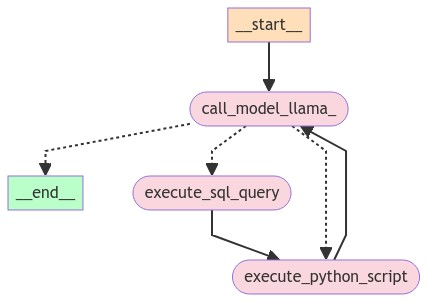

In [9]:
from IPython.display import Image, display

print("llama3 Agent :- ")
display(Image(app_llama3.get_graph().draw_mermaid_png()))

print("gpt Agent :- ")
display(Image(app_gpt.get_graph().draw_mermaid_png()))

In [10]:
# llama3 output 

output_llama3 = app_llama3.invoke({"messages": [("human", "Graph the total number of orders of each customer. X axis of the graph has to be in ascending order.")]})
print(output_llama3["messages"][-1].content)

In [11]:
# gpt output 

output_gpt = app_gpt.invoke({"messages": [("human", "Graph the total number of orders of each customer. X axis of the graph has to be in ascending order.")]})
print(output_gpt["messages"][-1].content)

## Attaching customer feedback summarization tool chain 

llama3 Agent :- 


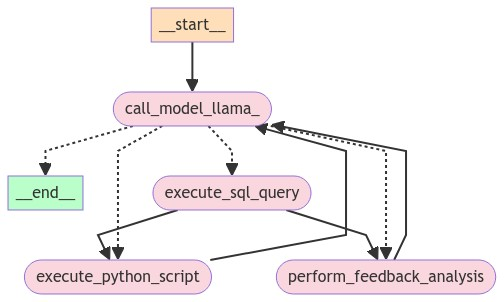

In [16]:
# Tool schema for writing Python code
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List
from langchain_agents._utils import upload_dfs_to_python_env, execute_script, convert_python_result_to_msg_content

class get_feedbacks(BaseModel):
    """Execute a PostgreSQL SELECT statement to gather customer feedbacks and use the results to create a DataFrame with the given column names."""
    select_query: str = Field(..., description="A PostgreSQL SELECT statement to get feedbacks with their feedback_ids, order_ids and customer_ids.")
    df_columns: List[str] = Field(
        ..., description="Ordered names to give the DataFrame columns."
    )
    df_name: str = Field(
        ..., description="The name to give the DataFrame variable in downstream code."
    )

class analyse_feedbacks(BaseModel):
    """Get the total number of feedbacks. Make sure to print it."""

    code: str = Field(
        ...,
        description="The code to get the total number of feedbacks. Make sure to print it.",
    )

system_prompt = f"""\
You are an expert at PostgreSQL and Python. You have access to a PostgreSQL database \
with the following tables

{db.table_info}

Given a user question related to the data in the database, \
if the user asks to analyse the sentiments of feedbacks, use get_feedbacks to get relevant data as a Dataframe. \
Then use analyse_feedbacks to get a rating and small summary for the selected feedbacks. \
If user need to know any other database related information, get the relevant data from the tables as a DataFrame using the create_df_from_sql tool. \
Then use the python_shell to do any analysis required to answer the user question."""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("placeholder", "{messages}"),
    ]
)


# Defining different call model nodes for each LLM
def call_model_llama3(state: AgentState) -> dict:
    """Call model with tools passed in."""
    messages = []

    chain = prompt | llm_llama3.bind_tools([create_df_from_sql, python_shell, get_feedbacks, analyse_feedbacks])
    messages.append(chain.invoke({"messages": state["messages"]}))

    return {"messages": messages}

def execute_sql_query(state: AgentState) -> dict:
    """Execute the latest SQL queries."""
    messages = []

    for tool_call in state["messages"][-1].tool_calls:
        if tool_call["name"] not in ("create_df_from_sql", "get_feedbacks"):
            continue

        print(f"tool_call['name'] :- {tool_call['name']}")
        # Execute SQL query
        print(f"select_query :- {tool_call['args']['select_query']}")
        print("-------------------------")
        res = db.run(tool_call["args"]["select_query"], fetch="cursor").fetchall()
    
        # Convert result to Pandas DataFrame
        df_columns = tool_call["args"]["df_columns"]
            
        print(f"df_columns :- {df_columns}")
        print(f"res :- {res}")
        print("-------------------------")
            
        df = pd.DataFrame(res, columns=df_columns)
        df_name = tool_call["args"]["df_name"]
    
        # Saving generated df to reduce memory usage 
        df_dir = ''
        df_path = f"{df_dir + df_name}" + '.csv'
        df.to_csv(df_path)
        del df
    
        # Add tool output message
        messages.append(
            RawToolMessage(
                f"Generated dataframe {df_name} with columns {df_columns}",  # What's sent to model.
                raw={df_name: df_path},
                tool_call_id=tool_call["id"],
                tool_name=tool_call["name"],
            )
        )

    return {"messages": messages}
    

# class FeedbackAnalysis(BaseModel):
#     """Information from Feedback"""
    
#     rating: int = Field(
#         description="The sentiment score which is calculated using the customer feedback. It has to be on a scale of 1 to 10, where 1 represents extremely negative sentiment and 10 represents extremely positive sentiment"
#     )
#     summary: str = Field(
#         default=None, 
#         description=("A very short summary of the feedback with keywords and phrases which have affected the sentiment score."
#                     "This has to be less than 30 words. Make it as short as possible.")
#     )

# chain = prompt | model.with_structured_output(schema=FeedbackAnalysis)


def perform_feedback_analysis(state: AgentState) -> dict:
    """
    Execute the latest generated Python code.
    """
    messages = []

    last_ai_msg = [msg for msg in state["messages"] if isinstance(msg, AIMessage)][-1]
    for tool_call in last_ai_msg.tool_calls:
        if tool_call["name"] != "analyse_feedbacks":
            continue

        df_code = upload_dfs_to_python_env(state)
        generated_code = tool_call["args"]["code"]
        print("-------------------------------------------")
        print("This is feedback analysis function !")
        print(f"df_code :- {df_code}")
        print(f"AI generated_code :- \n{generated_code}")
        
        python_result = execute_script(df_code + "\n" + generated_code)
        print(f"perform_feedback_analysis python_result :- {python_result}")
        print("-------------------------------------------")

        messages.append(
            RawToolMessage(
                convert_python_result_to_msg_content(python_result),
                raw=python_result,
                tool_call_id=tool_call["id"],
                tool_name=tool_call["name"],
            )
        )
    return {"messages": messages}

# Create llama3 Agent 
workflow_llama3 = StateGraph(AgentState)

workflow_llama3.add_node("call_model_llama3", call_model_llama3)
workflow_llama3.add_node("execute_sql_query", execute_sql_query)
workflow_llama3.add_node("perform_feedback_analysis", perform_feedback_analysis)
workflow_llama3.add_node("execute_python_script", execute_python_script)

workflow_llama3.set_entry_point("call_model_llama3")
workflow_llama3.add_edge("execute_sql_query", "execute_python_script")
workflow_llama3.add_edge("execute_sql_query", "perform_feedback_analysis")
workflow_llama3.add_edge("execute_python_script", "call_model_llama3")
workflow_llama3.add_edge("perform_feedback_analysis", "call_model_llama3")
workflow_llama3.add_conditional_edges("call_model_llama3", should_continue)

app_llama3 = workflow_llama3.compile()

print("llama3 Agent :- ")
display(Image(app_llama3.get_graph().draw_mermaid_png()))

call_model_llama3 state :- {'messages': [('human', 'Graph the total number of orders of each customer. X axis of the graph has to be in ascending order.')]}
tool_call['name'] :- create_df_from_sql
select_query :- SELECT customer_id, COUNT(order_id) as total_orders FROM orders GROUP BY customer_id ORDER BY customer_id ASC
-------------------------
df_columns :- ['customer_id', 'total_orders']
res :- [(1, 6), (2, 8), (3, 6), (4, 6), (5, 7), (6, 4), (7, 3), (8, 8), (9, 8), (10, 4), (11, 11), (12, 8), (13, 8), (14, 6), (15, 7)]
-------------------------
call_model_llama3 state :- {'messages': [('human', 'Graph the total number of orders of each customer. X axis of the graph has to be in ascending order.'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_tx3y', 'function': {'arguments': '{"select_query":"SELECT customer_id, COUNT(order_id) as total_orders FROM orders GROUP BY customer_id ORDER BY customer_id ASC","df_columns":["customer_id","total_orders"],"df_name":"or

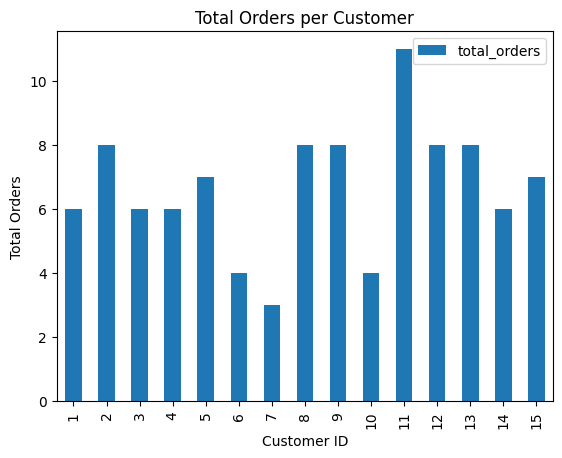

call_model_llama3 state :- {'messages': [('human', 'Graph the total number of orders of each customer. X axis of the graph has to be in ascending order.'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_tx3y', 'function': {'arguments': '{"select_query":"SELECT customer_id, COUNT(order_id) as total_orders FROM orders GROUP BY customer_id ORDER BY customer_id ASC","df_columns":["customer_id","total_orders"],"df_name":"orders_per_customer"}', 'name': 'create_df_from_sql'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 88, 'prompt_tokens': 2187, 'total_tokens': 2275, 'completion_time': 0.251428571, 'prompt_time': 0.81703473, 'queue_time': None, 'total_time': 1.068463301}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_753a4aecf6', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b789c86f-038c-4503-840c-41cb0c22b084-0', tool_calls=[{'name': 'create_df_from_sql', 'args': {'select_query': 'SELECT customer_id, COUNT(or

In [20]:
output_llama3 = app_llama3.invoke({"messages": [("human", "Graph the total number of orders of each customer. X axis of the graph has to be in ascending order.")]})
print(output_llama3["messages"][-1].content)

In [18]:
output_llama3 = app_llama3.invoke({"messages": [("human", "Give me a sentiment score for each feedback.")]})
print(output_llama3["messages"][-1].content)

call_model_llama3 state :- {'messages': [('human', 'Give me a sentiment score for each feedback.')]}
tool_call['name'] :- get_feedbacks
select_query :- SELECT * FROM feedback
-------------------------
df_columns :- ['feedback_id', 'order_id', 'feedback_text', 'rating']
res :- [(1, 1, 'Pizza was average.', 3), (2, 2, 'Pizza was average.', 3), (3, 3, 'Pizza was good.', 4), (4, 4, 'Pizza was average.', 3), (5, 5, 'Pizza was average.', 3), (6, 6, 'Pizza was average.', 3), (7, 7, 'Pizza was average.', 3), (8, 8, 'Pizza was average.', 3), (9, 9, 'Pizza was average.', 3), (10, 10, 'Pizza was slightly undercooked.', 2), (11, 11, 'Pizza was slightly undercooked.', 2), (12, 12, 'Pizza was average.', 3), (13, 13, 'Pizza was slightly undercooked.', 2), (14, 14, 'Pizza was slightly undercooked.', 2), (15, 15, 'Pizza was average.', 3), (16, 16, 'Pizza was slightly undercooked.', 2), (17, 17, 'Pizza was slightly undercooked.', 2), (18, 18, 'Pizza was good.', 4), (19, 19, 'Pizza was average.', 3), (20

KeyboardInterrupt: 